In [1]:
import matplotlib.pyplot as plt
import networkx as nx

In [4]:
with open('../data/friends-000______.txt') as f, open("../data/output.txt", "w") as w:
    for row in f:
        if 'private' not in row and 'notfound' not in row:
            row = row.replace(",", " ")
            row = row.replace(":", " ")
            w.write(row)

In [5]:
w.close()

In [9]:
G = nx.read_adjlist('../data/output.txt')

In [10]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 3051181
Number of edges: 10724270
Average degree:   7.0296


In [11]:
H = G.subgraph(['102', '101', '181', '794', '798', '804', '811', '814', '821', '996', '6319', '6533', '40495', '148648',
                '861441', '967502', '1064745', '1077747', '2806491', '9229534', '17838679', '104', '1143', '628701', 
                '2438054', '107', '134', '385', '386', '520', '634835', '834879', '2743054', '13312740', '112', '113', 
                '398234', '429887', '3901400', '18449866', '23921615', '349', '98405', '1184372', '1621447', '2167080', 
                '2425437', '9573889', '9738716'])

In [12]:
sorted(nx.common_neighbors(H, '101', '102'))

['181', '40495']

In [13]:
def friends_of_friends_set(G, friends):
    """Given a set of friends, returns a set of friends of friends"""
    friends_of_friends = set()

    for f in friends:
        friends_of_friends.update(G.neighbors(f))

    return friends_of_friends

In [14]:
 def make_remove_set(G, node, friends_of_friends):
    """Removes friends of friends that a user is already friends with"""
    remove_set = set()
    for fof in friends_of_friends:
        if not G.has_edge(node, fof) and fof != node:
            remove_set.add(fof)
    return remove_set

In [15]:
def calculate_degree(G, friends, f):
    """
    Calculate degree of closeness between 2 people.
    Inputs:
        G: network
        friends: list of person's friends
        f: potential friend
    Returns:
        degree of closeness between the person and f
    """ 
    num_friends = len(friends)
    fs_friends = list(H.neighbors(f))
    friends_in_common = list(set(friends).intersection(fs_friends))
    degree = len(friends_in_common)/(len(friends)+len(fs_friends))
    return degree

In [25]:
def top_k_recs(G, friends, fof, k=5):
    """
    Given list of friends of friends, return 5 with highest degree
    Inputs:
        G: network
        friends: list of person's friends
        fof: list of potential friends
    Returns:
        sorted list of top k potential friends
    """
    degree_dict = {}
    for f in fof:
        deg = calculate_degree(G, friends, f)
        degree_dict[f] = deg
    # Sort by dict values
    sorted_list = sorted(degree_dict, key=degree_dict.get, reverse=True)
    return sorted_list[:k]

In [17]:
def format_recs(user_id, recs, k=5):
    """Print 5 friend recommendations to terminal"""
    print('Top {} friend recommendations for user {}:'.format(k, user_id))
    for i, r in enumerate(recs):
          print('#' + str(i+1) + ': ' + str(r))

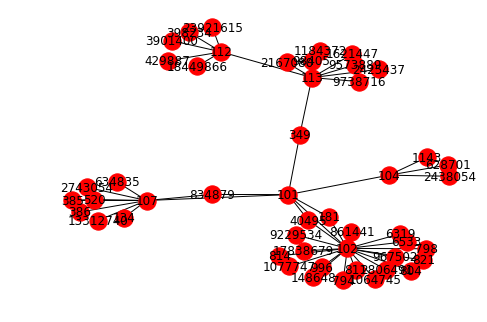

In [18]:
nx.draw(H, with_labels = True)

In [24]:
person = '101'

friends = set(H.neighbors(person))
fof = friends_of_friends_set(H, friends)
potential_friends = make_remove_set(H, person, fof)
recs = top_k_recs(H, friends, potential_friends, k=10)
format_recs(person, recs, k=10)

0.125
0.1111111111111111
0.125
0.1111111111111111
0.125
0.125
0.125
0.0625
0.125
0.125
0.1111111111111111
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.1111111111111111
0.125
0.125
0.125
0.125
Top 10 friend recommendations for user 101:
#1: 861441
#2: 148648
#3: 634835
#4: 967502
#5: 811
#6: 804
#7: 628701
#8: 9229534
#9: 2743054
#10: 798


## MapReduce

In [82]:
from mrjob.job import MRJob

In [84]:
class MRFriendsInCommon(MRJob):
    def mapper(line):
        parsed_line = ":".split(line)
        person = parsed_line[0]
        friends = parsed_line[1:]
        for friend in friends:
            pair = sorted(person, friends)
            yield pair, friends
            
    def reducer(pair, friends):
        friends_in_common = list(set(friends[0]).intersection(friends[1]))
        yield pair, friends_in_common